In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets
from matplotlib import pyplot
import numpy
import pymc3 as pm
import scipy.optimize
import scipy.stats


import calibr8

### Synthetic groundtruth

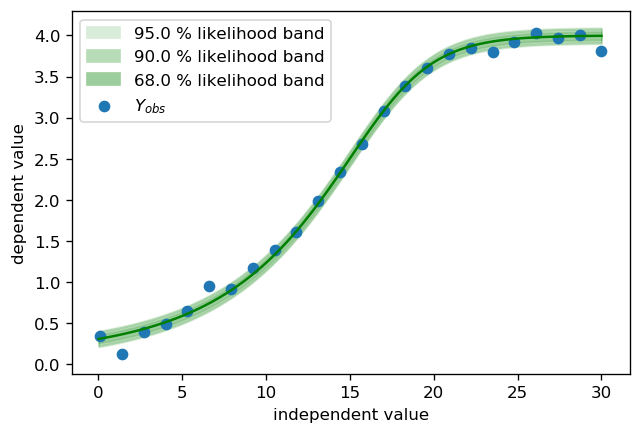

In [3]:
θ_true = (0.1, 4, 15, 0.3, 1)
σ_true = 0.05
df_true = 1.5
X = numpy.linspace(0.1, 30, 24)
X_dense = numpy.linspace(0, 30, 100)
Y = calibr8.asymmetric_logistic(X, θ_true)
numpy.random.seed(230620)
Y = scipy.stats.t.rvs(loc=Y, scale=σ_true, df=df_true)

fig, ax = pyplot.subplots(dpi=120)

calibr8.plot_norm_band(ax, X_dense, calibr8.asymmetric_logistic(X_dense, θ_true), σ_true)

ax.scatter(X, Y, label='$Y_{obs}$')

ax.set_xlabel('independent value')
ax.set_ylabel('dependent value')
ax.legend()
pyplot.show()

### Model definition

In [4]:
class AsymmetricTModelV1(calibr8.BaseAsymmetricLogisticT):
    def __init__(self):
        super().__init__(independent_key='independent', dependent_key='dependent', scale_degree=0)

### Model fit

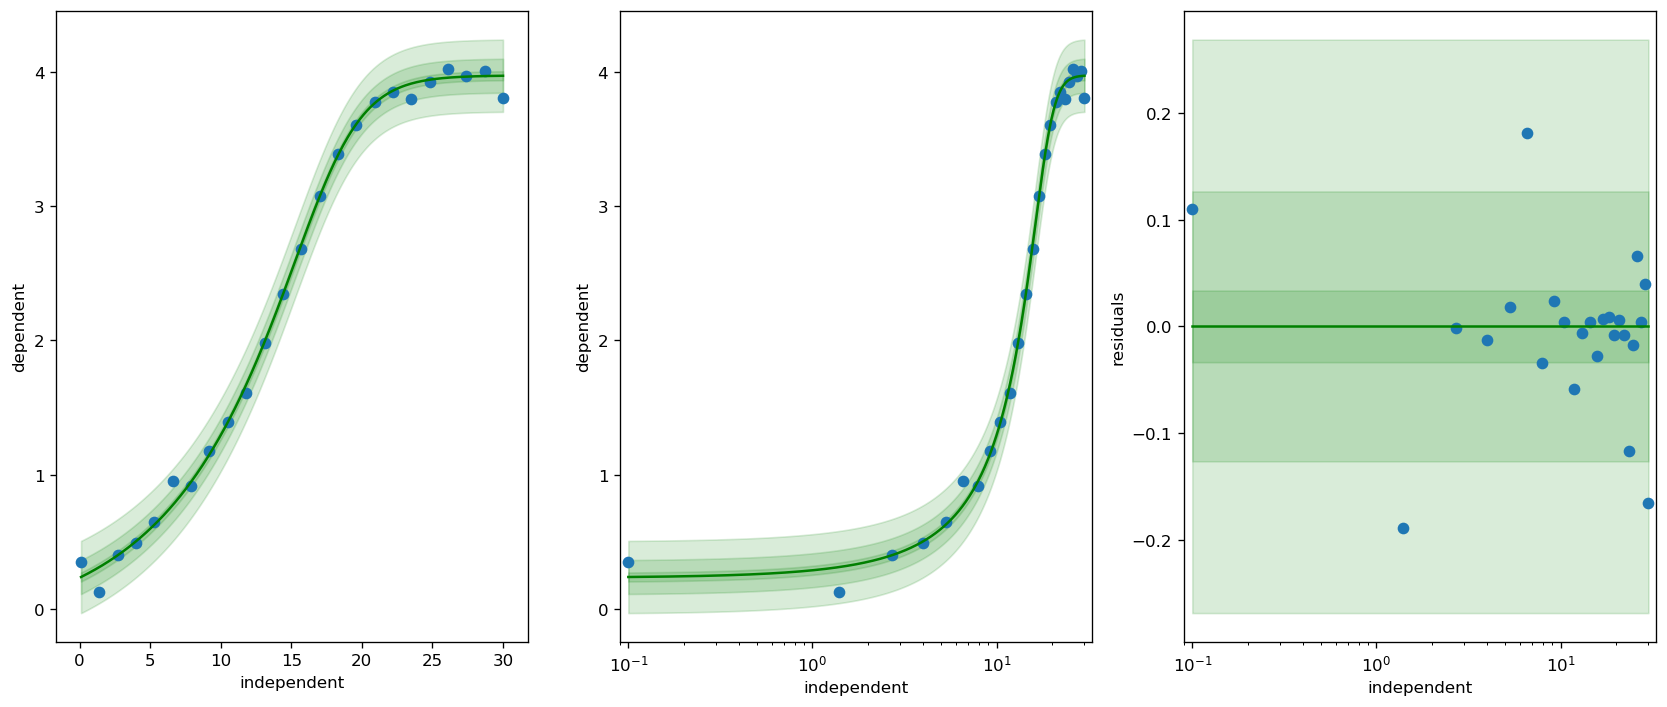

The following estimations were made for ('L_L', 'L_U', 'I_x', 'S', 'c', 'scale_0', 'df'): [-0.16186002  3.97496831 15.2625977   0.286587    1.35543445  0.01744913
  0.92509783]


In [5]:
model = AsymmetricTModelV1()
calibr8.fit_scipy(
    model,
    independent=X, dependent=Y,
    theta_guess=calibr8.guess_asymmetric_logistic_theta(X, Y) + [0.01, 5],
    #theta_guess=θ_true + (σ_true, df_true),
    theta_bounds=calibr8.guess_asymmetric_logistic_bounds(X, Y) + [(0.01, 0.5), (0.5, 50)]
)

fig, axs = calibr8.plot_model(model)
fig.tight_layout()
pyplot.show()
print(f'The following estimations were made for {model.theta_names}: {model.theta_fitted}')

### Visualization

In [6]:
def plot(y_obs=0.5, a=0, b=30, steps=1000, percentiles=True):
    y_obs = numpy.atleast_1d(y_obs)
    x, pdf = model.infer_independent(y_obs, lower=a, upper=b, steps=steps, percentiles=percentiles)
    
    fig, ax = pyplot.subplots(dpi=120)
    ax.plot(x, pdf, label='probability(x)')
    for yo in y_obs:
        ax.axvline(model.predict_independent(yo), linestyle='--', label='predict_independent')
    
    ax.legend()
    ax.set_xlabel('independent variable')
    ax.set_ylabel('$p(x\ |\ y_{obs})$')
    return fig, ax

ipywidgets.interact(
    plot,
    y_obs=θ_true[0:2],
    a=ipywidgets.fixed(0),
    b=ipywidgets.fixed(30), 
    steps=ipywidgets.fixed(1000)
);

interactive(children=(FloatSlider(value=0.5, description='y_obs', max=4.0, min=0.1), Checkbox(value=True, desc…

### Comparison with MCMC

In [7]:
y_obs = numpy.array([3.85,3.9])
a = 0
b = 30

theta = model.theta_fitted
with pm.Model():
    prior = pm.Uniform(model.independent_key, lower=a, upper=b, shape=(1,))
    mu, scale, df = model.predict_dependent(prior, theta=theta)
    pm.StudentT('likelihood', nu=df, mu=mu, sigma=scale, observed=y_obs, shape=(1,))
    trace = pm.sample(10000, cores=1, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [independent]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 89 seconds.
The acceptance probability does not match the target. It is 0.9120411756915142, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


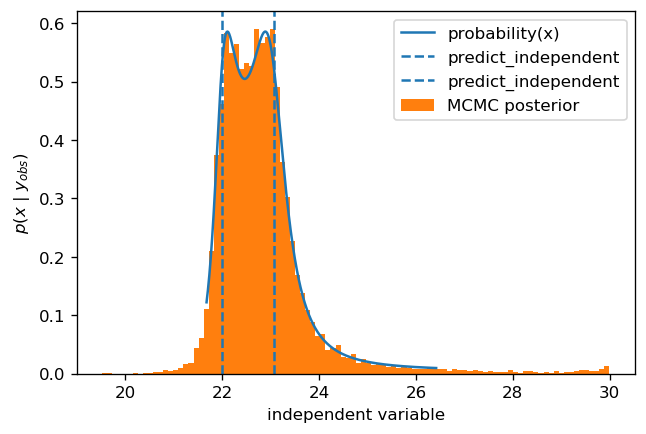

In [8]:
fig, ax = plot(y_obs=y_obs)#, percentiles=False)
ax.hist(
    trace.posterior['independent'].stack(sample=('chain', 'draw')).values.T,
    density=True, bins=100, 
    label='MCMC posterior'
)
ax.legend()
pyplot.show()

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

ipywidgets 7.5.1
calibr8    4.0.2
pymc3      3.9.1
numpy      1.18.1
scipy      1.3.2
last updated: Mon Jun 29 2020 

CPython 3.6.10
IPython 7.11.1
watermark 2.0.2
